In [1]:
import os
import pandas as pd
import nltk
import re
import stanza
import numpy as np
#stanza.download("cs")
nlp = stanza.Pipeline("cs")

/srv/venvs/default_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-30 11:49:03 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-04-30 11:49:03 INFO: Downloaded file to /home/jupyter-vojta/stanza_resources/resources.json
2025-04-30 11:49:04 INFO: Loading these models for language: cs (Czech):
| Processor | Package      |
----------------------------
| tokenize  | pdt          |
| mwt       | pdt          |
| pos       | pdt_nocharlm |
| lemma     | pdt_nocharlm |
| depparse  | pdt_nocharlm |

2025-04-30 11:49:04 INFO: Using device: cuda
2025-04-30 11:49:04 INFO: Loading: tokenize
2025-04-30 11:49:05 INFO: Loading: mwt
2025-04-30 11:49:05 INFO: 

In [2]:
files_df = pd.read_json("../data/files_df.json")

In [3]:
files_df.shape

(11617, 5)

In [5]:
files_df["filename"] = files_df["file_url"].apply(lambda x: x.rpartition("/")[2].replace(".pdf", ".txt"))

In [6]:
files_df.drop_duplicates(subset="filename", keep="first", inplace=True)

In [8]:
x = "psi_1986_2_vina_ocr.txt"
re.search(r"19\d{2}", x).group()

'1986'

In [10]:
def year_from_filename(filename):
    try:
        return int(re.search(r"19\d{2}", filename).group())
    except:
        return None
files_df["year"] = files_df["filename"].apply(year_from_filename)

<Axes: >

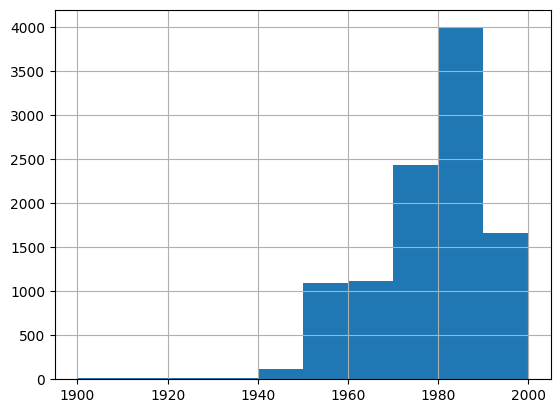

In [11]:
decade_bins = np.arange(files_df["year"].min(), files_df["year"].max() + 10, 10)
files_df["year"].hist(bins=decade_bins)

In [12]:
path = "../data/rawtexts/"
filenames = os.listdir(path)
len(filenames)

11615

In [13]:
files_df["filename"].apply(lambda x: x in filenames).sum()

np.int64(11614)

In [21]:
filename = filenames[16]
with open(path + filename) as f:
    text = f.read()

In [15]:
path = "../data/rawtexts/"

def get_numbers(filename):
    try:
        with open(path + filename) as f:
            text = f.read()
        pages_N = len(re.findall(r"\[pageend\d+\]", text))
        text = re.sub(r"\[pageend\d+\]", " ", text)
        text = re.sub(r'(\w+)- (\w+)', r'\1\2', text)
        tokens = nltk.word_tokenize(text)
        tokens_N = len(tokens)
        return pages_N, tokens_N 
    except:
        return 0, 0

In [ ]:
files_df[['pages_N', 'tokens_N']] = files_df['filename'].apply(get_numbers).apply(pd.Series)

In [22]:
[match[1] for match in re.findall("(\.\s)(.*\sbezpečí.*\.)(\s)", text)]

['Pro krajany, kteří nechtějí držet volant v ruce v době dovolené a nebo ty, kteří nemají vl. vozidlo, můžeme zprostředkovat jízdu s luxus- autobusovou pravidlenou linkou z Feldkirchu (Rakousko) přes Nizzu nebo La Spezia až do naší vesničky a zpět. Dále pořádáme podzimní mimořádný zájezd na vinobraní do naší vesničky a zpět. Ve všech případech si vyžádejte informace Od roku 1985 se stává penzijní pojištění povinným. Mnoho z Vás pracuje u malých podniků, které dosud penzijní pojištění nemají. Rádi již nyní poskytneme Vašim zaměstnavatelům přesné informace.^ Upozorněte je na naší vzornou pojištovnu. I krajanům, kteří pracují samostatně s málo zaměstnanci (projektanti, lékaři, programátoři, obchody, i dílny) vysvětlíme přednost penzijního poj. od nás. Váš dlouholetý pracovník poj. Neuenburger M. David Tel. 053/7 73 91 NEČTETE ZPRAVODAJ * * * * * * * * ZADARMO? NAŠE SPECIALITY Vhodný dárek pro vaše německy mluvící přátele: Hrušová J./Janacekova L-: Von Liwan- zen, Kolatschen und Budweiser 

In [28]:
target = "bezpečí"
output_dir = "../data/sentences_bezpeci/"
try:
    os.mkdir(output_dir)
except:
    pass
def get_concordances(filename, target, output_dir):
    try:
        with open(path + filename) as f:
            text = f.read()
        text = re.sub("\[pageend\d+\]", " ", text)
        text = re.sub(r'(\w+)- (\w+)', r'\1\2', text)
        #tokens = nltk.word_tokenize(text)
        matches = re.findall(r'[^\.]*?\b{}\b[^\.]*\.'.format(target), text, re.IGNORECASE)
        if len(matches) > 0:
            concordances = []
            for sent in matches:
                doc = nlp(sent)
                concordances.append(" ".join([t.lemma for t in doc.sentences[0].words if (t.upos in ["PROPN", "NOUN", "VERB", "ADJ"]) & (len(t.lemma) > 2)]) + "\n")
            pathfn = output_dir + filename
            with open(pathfn, 'w') as f:
                f.writelines(concordances)
            return len(matches)
        else:
            return 0
    except:
        return 0


In [23]:
matches = re.findall(r'[^\.]*?\bbezpečí\b[^\.]*\.', text)
matches

['" Na jedné straně Patrick White, jehož ústy mluví milióny, zanícené pro mír, na druhé Sacharov a Solženicyn; na jedné straně člověk, který se z pohodlného bezpečí demokratického zátiší domnívá, že zná rub mince, na druhé lidé, kteří jej znají opravdu, protože jím byli krůtě postiženi.']

### Lemmatized concordances

In [29]:
target = "bezpečí"
output_dir = "../data/sentences_bezpeci/"
try:
    os.mkdir(output_dir)
except:
    pass
files_df["bezpečí_N"] = files_df["filename"].apply(lambda x: get_concordances(x, target, output_dir))

In [30]:
target = "nebezpečí"
output_dir = "../data/sentences_nebezpeci/"
try:
    os.mkdir(output_dir)
except:
    pass
files_df["nebezpečí_N"] =  files_df["filename"].apply(lambda x: get_concordances(x, target, output_dir))

In [31]:
target = "bezpečnost"
output_dir = "../data/sentences_bezpecnost/"
try:
    os.mkdir(output_dir)
except:
    pass
files_df["bezpečnost_N"] =  files_df["filename"].apply(lambda x: get_concordances(x, target, output_dir))

In [32]:
files_df.to_json("../data/files_Ns_df.json")

### Vocabulary sizes

In [2]:
files_df = pd.read_json("../data/files_Ns_df.json")

In [3]:
files_df.head(5)

,periodical_category,periodical_href,periodical_title,periodical_basic_info,file_url,filename,year,bezpečí_N,nebezpečí_N,bezpečnost_N
0,samizdat,/cs/periodika/ps-psi,Ψ [Psí],"[, [Praha] , 1985 – 1989 , 1 × ročně , ]",https://files.scriptum.cz/scriptum/%5Bnode%5D/...,psi_1986_2_vina_ocr.txt,1986.0,0,7,0
1,samizdat,/cs/periodika/ps-psi,Ψ [Psí],"[, [Praha] , 1985 – 1989 , 1 × ročně , ]",https://files.scriptum.cz/scriptum/%5Bnode%5D/...,psi_1987_3_freud-a-psychoanalyza_ocr.txt,1987.0,1,1,0
2,samizdat,/cs/periodika/ps-psi,Ψ [Psí],"[, [Praha] , 1985 – 1989 , 1 × ročně , ]",https://files.scriptum.cz/scriptum/%5Bnode%5D/...,psi_1988_4_sluzba-zivotu_rok-blahoslavene-anez...,1988.0,0,2,0
3,samizdat,/cs/periodika/ps-psi,Ψ [Psí],"[, [Praha] , 1985 – 1989 , 1 × ročně , ]",https://files.scriptum.cz/scriptum/%5Bnode%5D/...,psi_1989_5_vira-v-modernim-svete_ocr.txt,1989.0,0,1,0
4,samizdat,/cs/periodika/abecedni-casopis,Abecední časopis,"[, Praha , 1985 - 1986 , nepravidelně , ]",https://files.scriptum.cz/scriptum/abecedni-ca...,abecedni-casopis_1986_2_bonifac_tit-str-obsah_...,1986.0,0,0,0


In [17]:
files_df.head(5)

,periodical_category,periodical_href,periodical_title,periodical_basic_info,file_url,filename,year,bezpečí_N,nebezpečí_N,bezpečnost_N,pages_N,tokens_N
0,samizdat,/cs/periodika/ps-psi,Ψ [Psí],"[, [Praha] , 1985 – 1989 , 1 × ročně , ]",https://files.scriptum.cz/scriptum/%5Bnode%5D/...,psi_1986_2_vina_ocr.txt,1986.0,0,7,0,36,24524
1,samizdat,/cs/periodika/ps-psi,Ψ [Psí],"[, [Praha] , 1985 – 1989 , 1 × ročně , ]",https://files.scriptum.cz/scriptum/%5Bnode%5D/...,psi_1987_3_freud-a-psychoanalyza_ocr.txt,1987.0,1,1,0,42,21575
2,samizdat,/cs/periodika/ps-psi,Ψ [Psí],"[, [Praha] , 1985 – 1989 , 1 × ročně , ]",https://files.scriptum.cz/scriptum/%5Bnode%5D/...,psi_1988_4_sluzba-zivotu_rok-blahoslavene-anez...,1988.0,0,2,0,25,14764
3,samizdat,/cs/periodika/ps-psi,Ψ [Psí],"[, [Praha] , 1985 – 1989 , 1 × ročně , ]",https://files.scriptum.cz/scriptum/%5Bnode%5D/...,psi_1989_5_vira-v-modernim-svete_ocr.txt,1989.0,0,1,0,36,23867
4,samizdat,/cs/periodika/abecedni-casopis,Abecední časopis,"[, Praha , 1985 - 1986 , nepravidelně , ]",https://files.scriptum.cz/scriptum/abecedni-ca...,abecedni-casopis_1986_2_bonifac_tit-str-obsah_...,1986.0,0,0,0,2,87


In [18]:
files_df.to_json("../data/files_Ns_df.json")

### Raw sentences

In [25]:
target = "bezpečí"
output_dir = "../data/rawsentences_bezpeci/"
try:
    os.mkdir(output_dir)
except:
    pass
def get_concordances(filename, target, output_dir):
    try:
        if filename not in os.listdir(output_dir):
            with open(path + filename) as f:
                text = f.read()
                text = re.sub("\[pageend\d+\]", " ", text)
                text = re.sub(r'(\w+)- (\w+)', r'\1\2', text)
                #tokens = nltk.word_tokenize(text)
                matches = re.findall(r'[^\.\?\!]*?\b{}\b[^\.]*[\.\?\!]'.format(target), text, re.IGNORECASE)
                if len(matches) > 0:
                    matches = [match + '\n' for match in matches]
                    pathfn = output_dir + filename
                    with open(pathfn, 'w') as f:
                        f.writelines(matches)
                    return len(matches)
                else:
                    return 0
        else:
            return 0
    except:
        return 0 

In [26]:
%%time
output_dir = "../data/rawsentences_bezpeci/"
target = "bezpečím?"
for filename in filenames:
    get_concordances(filename=filename, target = target, output_dir =output_dir)

CPU times: user 30min 58s, sys: 10.9 s, total: 31min 9s
Wall time: 33min 31s


In [27]:
%%time
target = "bezpečnost[ií]?"
output_dir = "../data/rawsentences_bezpecnost/"
try:
    os.mkdir(output_dir)
except:
    pass
for filename in filenames:
    get_concordances(filename=filename, target=target, output_dir=output_dir)

CPU times: user 8min 49s, sys: 28.7 s, total: 9min 18s
Wall time: 9min 56s
